# Extraction des entités nommées

In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
import os
from typing import List, Dict, Tuple, Optional
import importlib
import models
import utils
importlib.reload(models)
importlib.reload(utils)
from models.models import *
from utils.datasetloader import NERDataset
from utils.fonctions import (
    load_jnlpba_dataset, load_ncbi_dataset,prepare_ncbi_for_ner,create_embedding_matrix_from_word2vec,load_word2vec_model,save_word2vec_model,train_word2vec_embeddings
)
from utils.creation_vocabulaire import create_vocab,create_char_vocab,preprocess_tokens,create_char_sequences,create_tag_mapping

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("Utilisation du dispositif : ","gpu" if torch.cuda.is_available() else "cpu")

Utilisation du dispositif :  gpu


## ÉTAPE 2: DATA PREPROCESSING

In [27]:
jnlpba_sentences, jnlpbaclasses = load_jnlpba_dataset("./datasets/JNLPBA")
print(jnlpba_sentences[1])

Chargement du dataset JNLPBA depuis: ./datasets/JNLPBA
- sentences: 22402 phrases
- 11 Classes: ['B-DNA', 'I-DNA', 'B-cell_line', 'I-cell_line', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-RNA', 'I-RNA', 'O']
[('Activation', 'O'), ('of', 'O'), ('the', 'O'), ('CD28', 'B-protein'), ('surface', 'I-protein'), ('receptor', 'I-protein'), ('provides', 'O'), ('a', 'O'), ('major', 'O'), ('costimulatory', 'O'), ('signal', 'O'), ('for', 'O'), ('T', 'O'), ('cell', 'O'), ('activation', 'O'), ('resulting', 'O'), ('in', 'O'), ('enhanced', 'O'), ('production', 'O'), ('of', 'O'), ('interleukin-2', 'B-protein'), ('(', 'O'), ('IL-2', 'B-protein'), (')', 'O'), ('and', 'O'), ('cell', 'O'), ('proliferation', 'O'), ('.', 'O')]


In [28]:
ncbi_data = load_ncbi_dataset("./datasets/NCBI-Corpus")
ncbi_sentences = prepare_ncbi_for_ner(ncbi_data)
print(ncbi_sentences[1])

Chargement du dataset NCBI depuis: ./datasets/NCBI-Corpus
Documents chargés: 793
Exemple d'entités dans le premier document: 2
Total de phrases générées (format JNLPBA): 7524

Vérification du format:
Type du premier élément: <class 'tuple'>
Longueur du tuple: 2
Type tokens: <class 'list'> (longueur: 16)
Type labels: <class 'list'> (longueur: 16)
Exemple tokens[:5]: ['Germline', 'mutations', 'in', 'BRCA1', 'are']
Exemple labels[:5]: ['O', 'O', 'O', 'O', 'O']
(['However', ',', 'the', 'function', 'of', 'the', 'BRCA1', 'protein', 'has', 'remained', 'elusive', '.'], ['I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'I-CompositeMention', 'O', 'O', 'O', 'O', 'O'])


Création de dataset JNLPBA

In [29]:
def create_jnlpba_dataloaders(jnlpba_sentences, batch_size=32, max_seq_len=100, word2vec_path=None):
    """ 
    Crée les Dataloaders avec Word2Vec
    """ 
    # 1. Créer les vocabulaires
    vocab = create_vocab(jnlpba_sentences, min_freq=2)
    char_vocab = create_char_vocab(jnlpba_sentences)
    
    # 2. Créer le mapping des tags
    tag_to_idx, idx_to_tag = create_tag_mapping(jnlpba_sentences)
    
    # 3. Diviser en train/dev/test
    total = len(jnlpba_sentences)
    train_size = int(0.7 * total)
    dev_size = int(0.15 * total)
    
    train_sentences = jnlpba_sentences[:train_size]
    dev_sentences = jnlpba_sentences[train_size:train_size + dev_size]
    test_sentences = jnlpba_sentences[train_size + dev_size:]
    
    print(f"JNLPBA - Train: {len(train_sentences)}, Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")
    
    # 4. Entraîner ou charger Word2Vec
    word2vec_model = None
    
    if word2vec_path:
        print(f"Tentative de chargement du modèle Word2Vec depuis: {word2vec_path}")
        word2vec_model = load_word2vec_model(word2vec_path)
    
    if word2vec_model is None:
        print("Entraînement d'un nouveau modèle Word2Vec...")
        
        # Extraire les phrases pour Word2Vec
        tokenized_sentences = [
        [token.lower() for token, label in sentence]
        for sentence in jnlpba_sentences
    ]
            
        
        print(f"Nombre de phrases pour Word2Vec: {len(tokenized_sentences)}")
        print(f"Exemple: {tokenized_sentences[0][:10]}")
        
        # Entraîner Word2Vec
        from gensim.models import Word2Vec
        word2vec_model = Word2Vec(
            sentences=tokenized_sentences,
            vector_size=200,
            window=5,
            min_count=2,
            workers=4,
            sg=1,  # Skip-gram
            epochs=10
        )
        
        print(f"Vocabulaire Word2Vec entraîné: {len(word2vec_model.wv)} mots")
        
        # Sauvegarder le modèle
        if word2vec_path:
            try:
                save_word2vec_model(word2vec_model, word2vec_path)
            except Exception as e:
                print(f"Attention: impossible de sauvegarder le modèle: {e}")
                print("Le modèle sera utilisé en mémoire seulement.")
    
    # 5. Créer la matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_word2vec(word2vec_model, vocab)
    
    # 6. Créer les datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    
    # 7. Créer les Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'word2vec_model': word2vec_model
    }

BATCH_SIZE = 32
results_jnlpba = create_jnlpba_dataloaders(jnlpba_sentences,batch_size=BATCH_SIZE,word2vec_path="./word2Vecembeddings/jnlpba_word2vec")

Format vocab: Liste de paires (token, label)
Vocabulaire créé: 12664 mots
Mots uniques: 22678
Mots avec fréquence >= 2: 12661
Format char vocab: Liste de paires (token, label)
Vocabulaire caractères créé: 85 caractères
Caractères uniques: 83
Format tag mapping: Liste de paires (token, label)
Mapping tags créé: 12 tags uniques
Tags: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']
JNLPBA - Train: 15681, Dev: 3360, Test: 3361
Tentative de chargement du modèle Word2Vec depuis: ./word2Vecembeddings/jnlpba_word2vec
Modèle Word2Vec chargé: ./word2Vecembeddings/jnlpba_word2vec
Mots trouvés dans Word2Vec: 12661
Mots non trouvés: 0
Couverture: 100.00%
Dataset créé: 15681 phrases valides
Dataset créé: 3360 phrases valides
Dataset créé: 3361 phrases valides


In [6]:
train_loader = results_jnlpba['train_loader']

# Récupérer un batch
for batch in train_loader:
    word_ids, char_seqs, tag_ids, lengths = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word = {v:k for k,v in results_jnlpba['vocab'].items()}  # optionnel si tu veux décoder
idx_to_tag = results_jnlpba['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids[0])
print("Char IDs :", char_seqs[0])
print("Tag IDs  :", tag_ids[0])
print("Longueur réelle:", lengths[0])

# Pour afficher les mots et labels décodés
decoded_words = [idx_to_word.get(w.item(), '<UNK>') for w in word_ids[0][:lengths[0]]]
decoded_tags  = [idx_to_tag[t.item()] for t in tag_ids[0][:lengths[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words, decoded_tags))) 

word_ids shape: torch.Size([32, 100])
char_seqs shape: torch.Size([32, 100, 20])
tag_ids shape: torch.Size([32, 100])
lengths: tensor([19, 33, 12, 20, 43, 39, 15, 33, 23, 32, 13, 40, 40, 31, 13, 28, 35, 12,
        33, 31, 12, 24, 31, 24, 23,  8, 13, 24, 30, 22, 33, 34])

Premier exemple du batch:
Word IDs : tensor([2467,   61, 3681,  561,  878,  880,  113, 7248,   68, 1452,   42,  351,
          19, 1739,   67,  111,  104,  347,   18,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
Char IDs : tensor

In [7]:
def create_ncbi_dataloaders(ncbi_sentences, batch_size=32, max_seq_len=200, word2vec_path=None):
    """
    Crée les DataLoaders pour NCBI avec Word2Vec
    """
    # 1. Créer les vocabulaires
    vocab = create_vocab(ncbi_sentences, min_freq=2)
    char_vocab = create_char_vocab(ncbi_sentences)
    
    # 2. Créer le mapping des tags
    tag_to_idx, idx_to_tag = create_tag_mapping(ncbi_sentences)
    
    # 3. Diviser en train/dev/test
    total = len(ncbi_sentences)
    train_size = int(0.7 * total)
    dev_size = int(0.15 * total)
    
    train_sentences = ncbi_sentences[:train_size]
    dev_sentences = ncbi_sentences[train_size:train_size + dev_size]
    test_sentences = ncbi_sentences[train_size + dev_size:]
    
    print(f"NCBI - Train: {len(train_sentences)}, Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")
    
    # 4. Entraîner ou charger Word2Vec
    if word2vec_path and os.path.exists(word2vec_path):
        print(f"Chargement du modèle Word2Vec depuis: {word2vec_path}")
        word2vec_model = load_word2vec_model(word2vec_path)
    else:
        print("Entraînement d'un nouveau modèle Word2Vec...")
        # Entraîner sur toutes les données
        word2vec_model = train_word2vec_embeddings(ncbi_sentences)
        
        # Sauvegarder le modèle
        if word2vec_path:
            save_word2vec_model(word2vec_model, word2vec_path)
    
    # 5. Créer la matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_word2vec(word2vec_model, vocab)
    
    # 6. Créer les datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    
    # 7. Créer les Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'word2vec_model': word2vec_model
    }
    
results_ncbi = ncbi_data_loaders = create_ncbi_dataloaders(
    ncbi_sentences,
    batch_size=BATCH_SIZE,
    word2vec_path="./word2Vecembeddings/ncbi"
)

Format vocab: Tuple (tokens, labels)
Vocabulaire créé: 5925 mots
Mots uniques: 10845
Mots avec fréquence >= 2: 5922
Format char vocab: Tuple (tokens, labels)
Vocabulaire caractères créé: 86 caractères
Caractères uniques: 84
Format tag mapping: Tuple (tokens, labels)
Mapping tags créé: 10 tags uniques
Tags: ['B-CompositeMention', 'B-DiseaseClass', 'B-Modifier', 'B-SpecificDisease', 'I-CompositeMention', 'I-DiseaseClass', 'I-Modifier', 'I-SpecificDisease', 'O']
NCBI - Train: 5266, Dev: 1128, Test: 1130
Entraînement d'un nouveau modèle Word2Vec...
Nombre de phrases pour Word2Vec: 7524
Première phrase: ['germline', 'mutations', 'in', 'brca1', 'are', 'responsible', 'for', 'most', 'cases', 'of']...
Entraînement du modèle Word2Vec...
Vocabulaire Word2Vec: 5922 mots
Taille des vecteurs: 200
Modèle Word2Vec sauvegardé: ./word2Vecembeddings/ncbi.model
Mots trouvés dans Word2Vec: 5922
Mots non trouvés: 0
Couverture: 100.00%
Dataset créé: 5266 phrases valides
Dataset créé: 1128 phrases valides
Dat

In [8]:
train_loader = results_ncbi['train_loader']

# Récupérer un batch
for batch in train_loader:
    word_ids, char_seqs, tag_ids, lengths = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word = {v:k for k,v in results_ncbi['vocab'].items()}  # optionnel si tu veux décoder
idx_to_tag = results_ncbi['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids[0])
print("Char IDs :", char_seqs[0])
print("Tag IDs  :", tag_ids[0])
print("Longueur réelle:", lengths[0])

# Pour afficher les mots et labels décodés
decoded_words = [idx_to_word.get(w.item(), '<UNK>') for w in word_ids[0][:lengths[0]]]
decoded_tags  = [idx_to_tag[t.item()] for t in tag_ids[0][:lengths[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words, decoded_tags))) 

word_ids shape: torch.Size([32, 200])
char_seqs shape: torch.Size([32, 200, 20])
tag_ids shape: torch.Size([32, 200])
lengths: tensor([26, 17, 22, 21, 33,  1, 25, 13,  1, 39, 40, 17, 12, 13, 26, 32, 47, 12,
        48, 10, 15, 15, 32, 15, 22, 24, 24, 24, 34, 18,  2, 20])

Premier exemple du batch:
Word IDs : tensor([  21,  434,  168,   76,  139,   80,   24,   66,  260, 1603,   38,   21,
        1597, 2060, 2913,   12,   21, 1001,   78,  281,   21,    1,   15, 5114,
        1602,   18,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 

Model architecture

In [30]:
from tqdm import tqdm
def train_epoch(model, dataloader, optimizer, device):
    """
    Entraînement pour une epoch avec CRF
    """
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader,total=len(dataloader),desc="Training"):
        word_ids, char_seqs, tag_ids, lengths = batch

        word_ids = word_ids.to(device)
        char_seqs = char_seqs.to(device)
        tag_ids = tag_ids.to(device)

        mask = (word_ids != 0)
        optimizer.zero_grad()
        # Passer les tags -> forward retourne la loss directement
        loss = model(word_ids, char_seqs, mask, tag_ids)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, device, idx_to_tag):
    """
    Evaluate model (CRF)
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            word_ids, char_seqs, tag_ids, lengths = batch

            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)

            mask = (word_ids != 0)

            # Calculer la loss (tags fournis)
            loss = model(word_ids, char_seqs, mask, tag_ids)
            total_loss += loss.item()

            # Décoder les séquences pour obtenir les prédictions
            predictions = model(word_ids, char_seqs, mask, tags=None)  # renvoie une list

            # Stocker les prédictions et targets
            for preds_seq, tag_seq, seq_len in zip(predictions, tag_ids, lengths):
                preds_seq = preds_seq[:seq_len]          # découper au vrai length
                tag_seq = tag_seq[:seq_len].cpu().numpy()  # tag_ids tensor -> numpy

                pred_tags = [idx_to_tag.get(idx, 'O') for idx in preds_seq]
                target_tags = [idx_to_tag.get(idx, 'O') for idx in tag_seq]

                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)

    return total_loss / len(dataloader), all_predictions, all_targets



def calculate_metrics(predictions, targets):
    """
    Calculate precision, recall, F1-score
    """
    from sklearn.metrics import precision_recall_fscore_support
    
    # Filter out 'O' tags for entity-specific metrics
    entity_preds = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O' or pred != 'O':
            entity_preds.append(pred)
            entity_targets.append(target)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        entity_targets, entity_preds, average='macro', zero_division=0
    )
    
    return precision, recall, f1


JNLPBA Dataset

In [35]:
def run_pipeline(
    dataset_name: str,
    loaders: dict,
    use_char_cnn: bool = False,
    use_char_lstm: bool = False,
    use_attention: bool = False,
    use_fc_fusion: bool = False,
    embedding_url: str = None,
    lstm_hidden_dim: Optional[int] = None,
    epochs: int = 40,
    patience: int = 6,
    checkpoints_dir="./checkpoints",
):
    train_loader = loaders['train_loader']
    dev_loader   = loaders['dev_loader']
    test_loader  = loaders['test_loader']

    vocab        = loaders['vocab']
    char_vocab   = loaders['char_vocab']
    tag_to_idx   = loaders['tag_to_idx']
    idx_to_tag   = loaders['idx_to_tag']
    comb_name = "WE"
    if use_char_cnn and use_char_lstm:
        comb_name += "_char_bilstm_cnn"
    elif use_char_cnn:
        comb_name += "_char_cnn"
    elif use_char_lstm:
        comb_name += "_char_bilstm"

    if use_attention:
        comb_name += "_attention"
    if use_fc_fusion:
        comb_name += "_fc"

    checkpoints_path = f"{checkpoints_dir}/{comb_name}/best_model.pt"
    os.makedirs(os.path.dirname(checkpoints_path), exist_ok=True)
    # Chargement des embeddings
    if embedding_url:
        pretrained_embeddings = load_word2vec_model(embedding_url)
    elif 'pretrained_embeddings' in loaders and loaders['pretrained_embeddings'] is not None:
        pretrained_embeddings = loaders['pretrained_embeddings']
    else:
        print("Embedding nul")
        return
    if lstm_hidden_dim is None:
        lstm_hidden_dim = 256 if dataset_name == 'JNLPBA' else 128
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = CombinatorialNER(
        vocab_size=len(vocab),
        char_vocab_size=len(char_vocab),
        tag_to_idx=tag_to_idx,
        use_char_cnn=use_char_cnn,
        use_char_lstm=use_char_lstm,
        use_attention=use_attention,
        use_fc_fusion=use_fc_fusion,
        pretrained_embeddings=pretrained_embeddings,
        word_embed_dim=200,
        lstm_hidden_dim=lstm_hidden_dim,
        dropout=0.5
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    
    # Scheduler: ReduceLROnPlateau (réduit le LR quand le plateau est atteint)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',        # On maximise le F1-score
        factor=0.5,        # Réduction de 50%
        patience=2,        # Attendre 2 epochs sans amélioration
        threshold=0.0001,  # Seuil d'amélioration minimum
        min_lr=1e-6        # Learning rate minimum
    )

    best_f1 = 0.0
    patience_counter = 0
    
    
    # Pour suivre l'historique
    history = {
        'train_loss': [],
        'dev_loss': [],
        'dev_f1': [],
        "dev_precision":[],
        "dev_recall":[],
        'lr': []
    }

    for epoch in range(epochs):
        # Entraînement
        train_loss = train_epoch(model, train_loader, optimizer, device)
        
        # Évaluation
        dev_loss, dev_preds, dev_targets = evaluate(model, dev_loader, device, idx_to_tag)
        precision, recall, f1 = calculate_metrics(dev_preds, dev_targets)
        
        # Mettre à jour le scheduler avec le F1-score
        scheduler.step(f1)
        
        # Sauvegarder l'historique
        history['train_loss'].append(train_loss)
        history['dev_loss'].append(dev_loss)
        history['dev_f1'].append(f1)
        history["dev_precision"].append(precision)
        history["dev_recall"].append(recall)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        print(
            f"Epoch {epoch+1:02d}/{epochs} | "
            f"Train loss: {train_loss:.4f} | "
            f"Dev loss: {dev_loss:.4f} | "
            f"P: {precision:.4f} R: {recall:.4f} F1: {f1:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_f1': best_f1,
            }, checkpoints_path)
            print(f"Meilleur modèle sauvegardé dans {checkpoints_path} : (F1: {f1:.4f})")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping triggered après {epoch+1} epochs.")
            break


    # Charger le meilleur modèle
    checkpoint = torch.load(checkpoints_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    test_loss, test_preds, test_targets = evaluate(
        model,
        test_loader,
        device,
        idx_to_tag
    )

    precision, recall, f1 = calculate_metrics(test_preds, test_targets)

    print("\n" + "="*50)
    print("RÉSULTATS FINAUX SUR LE TEST SET")
    print("="*50)
    print(f"Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("="*50)
    
    # Afficher l'historique des learning rates
    print("\nHistorique des learning rates:")
    for i, lr in enumerate(history['lr']):
        if i == 0 or lr != history['lr'][i-1]:
            print(f"  Epoch {i+1}: LR = {lr:.6f}")

    return model, history

Cobinaison WE

In [36]:
model_jnlpba_we, history_jnlpba_we = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn= False,
    use_char_lstm= False,
    use_attention= False,
    use_fc_fusion= False,
    embedding_url=None,
    epochs=40,
    patience=4,
    checkpoints_dir = "./checkpoints/JNLPBA",
)

Model parameters: 2,873,972


Training: 100%|██████████| 491/491 [00:57<00:00,  8.49it/s]


Epoch 01/40 | Train loss: 331.2494 | Dev loss: 183.4260 | P: 0.7269 R: 0.6378 F1: 0.6758 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE/best_model.pt : (F1: 0.6758)


Training: 100%|██████████| 491/491 [00:58<00:00,  8.33it/s]


Epoch 02/40 | Train loss: 133.9720 | Dev loss: 148.5541 | P: 0.7119 R: 0.7120 F1: 0.7109 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE/best_model.pt : (F1: 0.7109)


Training: 100%|██████████| 491/491 [00:56<00:00,  8.62it/s]


Epoch 03/40 | Train loss: 100.2503 | Dev loss: 137.5677 | P: 0.7405 R: 0.6964 F1: 0.7144 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE/best_model.pt : (F1: 0.7144)


Training: 100%|██████████| 491/491 [00:59<00:00,  8.32it/s]


Epoch 04/40 | Train loss: 81.4118 | Dev loss: 135.5715 | P: 0.7517 R: 0.6740 F1: 0.7084 | LR: 0.001000


Training: 100%|██████████| 491/491 [02:17<00:00,  3.58it/s]


Epoch 05/40 | Train loss: 67.8490 | Dev loss: 131.4471 | P: 0.7269 R: 0.7051 F1: 0.7146 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE/best_model.pt : (F1: 0.7146)


Training: 100%|██████████| 491/491 [00:58<00:00,  8.43it/s]


Epoch 06/40 | Train loss: 58.0747 | Dev loss: 132.5202 | P: 0.7313 R: 0.7093 F1: 0.7183 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE/best_model.pt : (F1: 0.7183)


Training: 100%|██████████| 491/491 [00:59<00:00,  8.30it/s]


Epoch 07/40 | Train loss: 49.6046 | Dev loss: 139.7421 | P: 0.7347 R: 0.6835 F1: 0.7061 | LR: 0.001000


Training: 100%|██████████| 491/491 [00:57<00:00,  8.61it/s]


Epoch 08/40 | Train loss: 42.5230 | Dev loss: 146.3857 | P: 0.7317 R: 0.6763 F1: 0.7015 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:10<00:00,  6.96it/s]


Epoch 09/40 | Train loss: 36.0703 | Dev loss: 150.0819 | P: 0.7199 R: 0.6865 F1: 0.7009 | LR: 0.000500


Training: 100%|██████████| 491/491 [01:49<00:00,  4.48it/s]


Epoch 10/40 | Train loss: 26.2862 | Dev loss: 158.8362 | P: 0.7166 R: 0.6878 F1: 0.7010 | LR: 0.000500

Early stopping triggered après 10 epochs.

RÉSULTATS FINAUX SUR LE TEST SET
Loss: 143.6743
Precision: 0.6610
Recall: 0.6694
F1-score: 0.6645

Historique des learning rates:
  Epoch 1: LR = 0.001000
  Epoch 9: LR = 0.000500


In [37]:
import pickle
import os

def save_vocabularies(data_dict, save_dir):
    """Sauvegarde les vocabulaires et mappings"""
    os.makedirs(save_dir, exist_ok=True)
    
    with open(os.path.join(save_dir, 'vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['vocab'], f)
    
    with open(os.path.join(save_dir, 'char_vocab.pkl'), 'wb') as f:
        pickle.dump(data_dict['char_vocab'], f)
    
    with open(os.path.join(save_dir, 'tag_to_idx.pkl'), 'wb') as f:
        pickle.dump(data_dict['tag_to_idx'], f)
    
    with open(os.path.join(save_dir, 'idx_to_tag.pkl'), 'wb') as f:
        pickle.dump(data_dict['idx_to_tag'], f)
    
    print(f"Vocabulaires sauvegardés dans {save_dir}")
    
save_vocabularies(results_jnlpba, './vocab/jnlpba')

Vocabulaires sauvegardés dans ./vocab/jnlpba


In [38]:
import matplotlib.pyplot as plt

def plot_training_history(history, dataset_name):
    """
    Visualise l'historique d'entraînement avec Loss, F1, Precision, Recall
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 11))
    fig.suptitle(f'Training History - {dataset_name}', fontsize=16, fontweight='bold')

    epochs = range(1, len(history['train_loss']) + 1)

    # ─────────────────────────────────────────────
    # Plot 1: Train vs Dev Loss
    # ─────────────────────────────────────────────
    axes[0, 0].plot(epochs, history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Train vs Dev Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 2: Dev Precision / Recall / F1
    # ─────────────────────────────────────────────
    axes[0, 1].plot(epochs, history['dev_precision'], label='Precision', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_recall'], label='Recall', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_f1'], label='F1-score', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_title('Dev Precision / Recall / F1')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 3: Learning Rate
    # ─────────────────────────────────────────────
    axes[1, 0].step(epochs, history['lr'], linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 4: Dev Loss vs F1 (double axis)
    # ─────────────────────────────────────────────
    ax_loss = axes[1, 1]
    ax_f1 = ax_loss.twinx()

    line1, = ax_loss.plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    line2, = ax_f1.plot(epochs, history['dev_f1'], label='Dev F1', linewidth=2)

    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_f1.set_ylabel('F1-score')
    ax_loss.set_title('Dev Loss & F1-score')

    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax_loss.legend(lines, labels, loc='upper right')

    ax_loss.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ─────────────────────────────────────────────
    # Résumé numérique final
    # ─────────────────────────────────────────────
    print(f"\nSTATISTIQUES FINALES - {dataset_name}")
    print(f"Meilleur F1 (dev)       : {max(history['dev_f1']):.4f}")
    print(f"Meilleure Precision(dev): {max(history['dev_precision']):.4f}")
    print(f"Meilleur Recall (dev)   : {max(history['dev_recall']):.4f}")
    print(f"Final train loss        : {history['train_loss'][-1]:.4f}")
    print(f"Final dev loss          : {history['dev_loss'][-1]:.4f}")
    print(f"Final learning rate     : {history['lr'][-1]:.6f}")


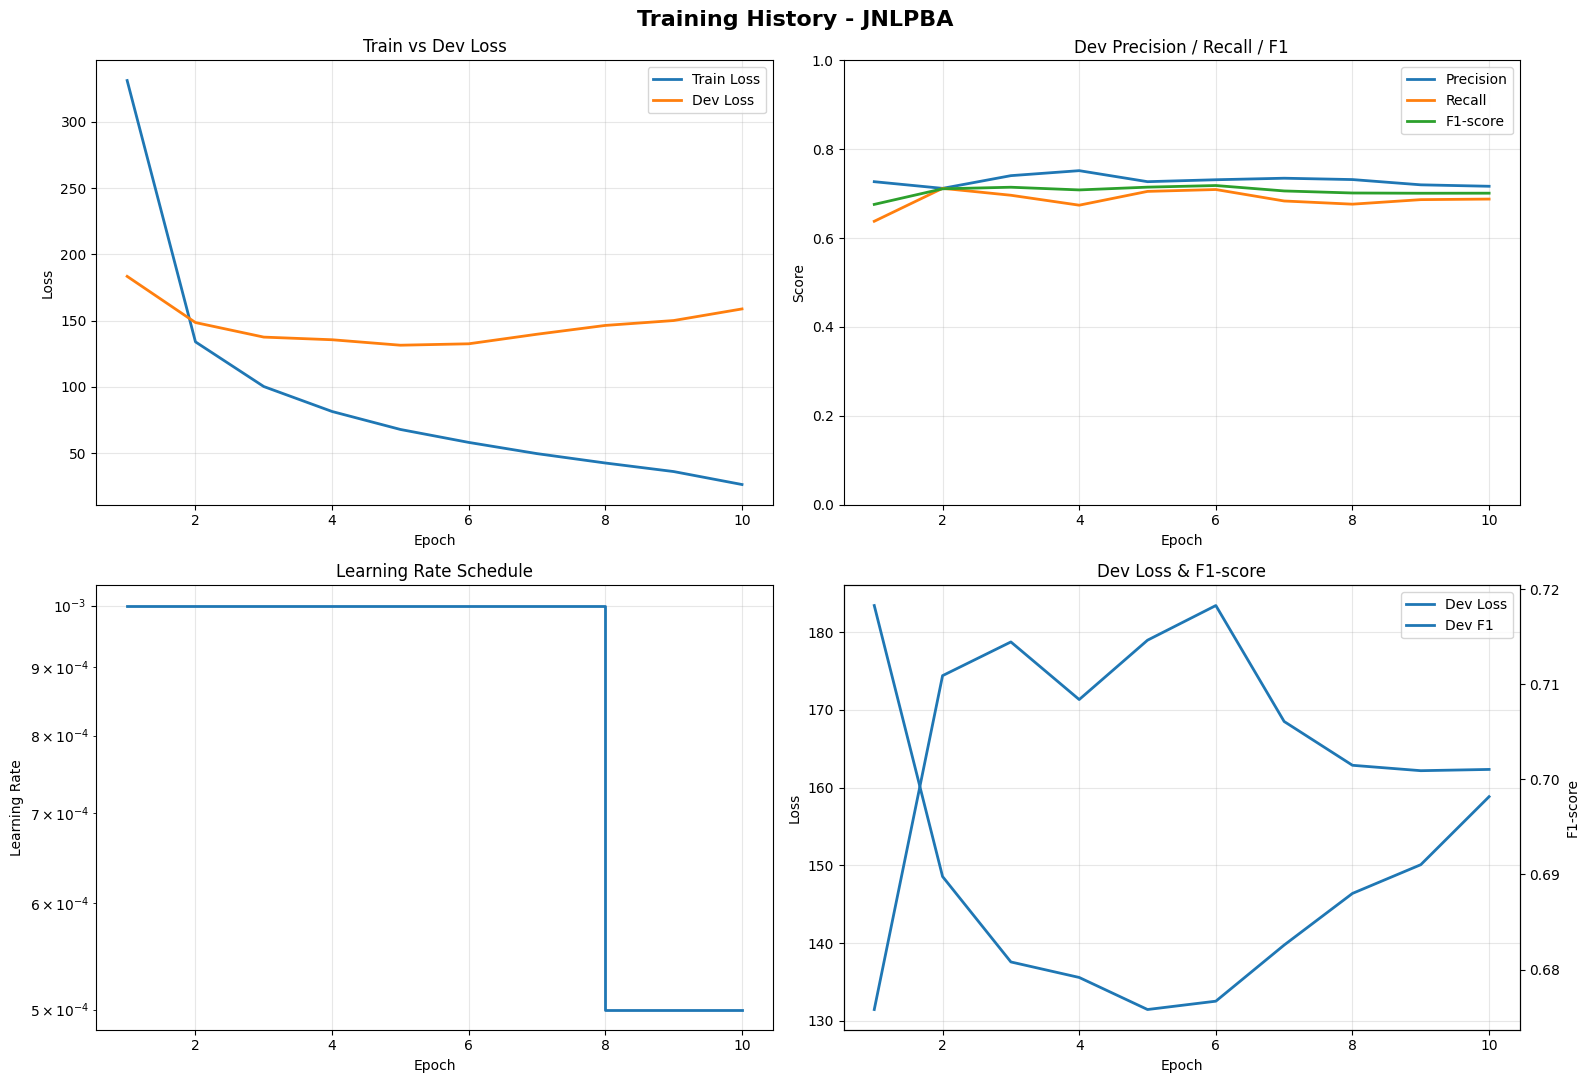


STATISTIQUES FINALES - JNLPBA
Meilleur F1 (dev)       : 0.7183
Meilleure Precision(dev): 0.7517
Meilleur Recall (dev)   : 0.7120
Final train loss        : 26.2862
Final dev loss          : 158.8362
Final learning rate     : 0.000500


In [39]:
plot_training_history(history_jnlpba_we, dataset_name="JNLPBA")

In [ ]:
def load_trained_model(model_path, dataset_name, loaders_dict,use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False):
    """
    Charge un modèle entraîné et le prépare pour les prédictions
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Récupérer les paramètres du loader
    vocab = loaders_dict['vocab']
    char_vocab = loaders_dict['char_vocab']
    tag_to_idx = loaders_dict['tag_to_idx']
    idx_to_tag = loaders_dict['idx_to_tag']
    
    # Déterminer les paramètres selon le dataset
    if dataset_name == 'JNLPBA':
        lstm_hidden = 256
    else:  # NCBI-Disease
        lstm_hidden = 128
    
    # Créer le modèle
    model = CombinatorialNER(
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=use_char_cnn,       
    use_char_lstm=use_char_lstm,      
    use_attention=use_attention,     
    use_fc_fusion=use_fc_fusion,      
    pretrained_embeddings=None,  
    word_embed_dim=200,
    lstm_hidden_dim=lstm_hidden,
    dropout=0.5
).to(device)

    
    # Charger les poids sauvegardés
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Mode évaluation
    
    print(f"Modèle chargé depuis: {model_path}")
    print(f"Best F1 enregistré: {checkpoint.get('best_f1', 'N/A'):.4f}")
    print(f"Époque: {checkpoint.get('epoch', 'N/A')}")
    
    return model, device, idx_to_tag

def plot_confusion_matrix_by_class(predictions, targets, idx_to_tag, dataset_name, 
                                   normalize=True, figsize=(12, 10)):
    """
    Affiche la matrice de confusion par classe avec des statistiques détaillées
    """
    # Vérification des types
    print(f"\nVérification des types:")
    print(f"  Type predictions[0]: {type(predictions[0])}, valeur: {predictions[0]}")
    print(f"  Type targets[0]: {type(targets[0])}, valeur: {targets[0]}")
    
    # S'assurer que tout est string
    predictions = [str(p) for p in predictions]
    targets = [str(t) for t in targets]
    
    # Filtrer les tags 'O' pour se concentrer sur les entités
    entity_predictions = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O':  
            entity_predictions.append(pred)
            entity_targets.append(target)
    
    print(f"\nStatistiques:")
    print(f"  Total tokens: {len(predictions)}")
    print(f"  Entity tokens: {len(entity_targets)}")
    print(f"  Unique entity tags in targets: {set(entity_targets)}")
    print(f"  Unique entity tags in predictions: {set(entity_predictions)}")
    
    # Obtenir les classes uniques (sauf 'O')
    all_unique_tags = sorted(set(entity_targets + entity_predictions))
    
    # Filtrer pour garder seulement les tags valides (pas les nombres)
    valid_tags = [tag for tag in all_unique_tags if not tag.isdigit()]
    
    # Si on a des tags numériques, c'est qu'il y a un problème de conversion
    numeric_tags = [tag for tag in all_unique_tags if tag.isdigit()]
    if numeric_tags:
        print(f"\nATTENTION: Tags numériques trouvés: {numeric_tags}")
        print("Cela indique que les prédictions sont des indices, pas des tags!")
        print(f"Mapping idx_to_tag: {dict(list(idx_to_tag.items())[:10])}")
    
    print(f"  Tags valides à plotter: {valid_tags}")
    
    if not valid_tags:
        print("Aucune entité valide trouvée dans les données!")
        return

    cm = confusion_matrix(entity_targets, entity_predictions, labels=valid_tags)
    supports = cm.sum(axis=1)  
    
    if normalize:
        # Éviter la division par zéro
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_normalized = cm.astype('float') / supports[:, np.newaxis]
            cm_normalized = np.nan_to_num(cm_normalized, nan=0.0)
        cm_to_plot = cm_normalized
        fmt = '.2f'
        title_suffix = '(Normalisée)'
    else:
        cm_to_plot = cm
        fmt = 'd'
        title_suffix = '(Absolue)'
    
    # Créer la figure
    plt.figure(figsize=figsize)
    
    # Si la matrice est trop grande, ajuster la taille
    if len(valid_tags) > 15:
        figsize = (max(12, len(valid_tags)), max(10, len(valid_tags)))
        plt.figure(figsize=figsize)
    
    sns.heatmap(cm_to_plot, annot=True, fmt=fmt, cmap='Blues', 
                xticklabels=valid_tags, yticklabels=valid_tags,
                cbar_kws={'label': 'Proportion' if normalize else 'Count'})
    
    plt.title(f'Matrice de Confusion - {dataset_name} {title_suffix}', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Prédictions', fontsize=12)
    plt.ylabel('Vraies labels', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    filtered_targets = []
    filtered_preds = []
    
    for t, p in zip(entity_targets, entity_predictions):
        if t in valid_tags and p in valid_tags:
            filtered_targets.append(t)
            filtered_preds.append(p)
    
    if filtered_targets:
        report = classification_report(filtered_targets, filtered_preds, 
                                       labels=valid_tags, zero_division=0)
        print(report)
    else:
        print("Pas assez de données pour générer le rapport")
    
    for i, tag in enumerate(valid_tags):
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        support = supports[i]
        
        # Éviter les divisions par zéro
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Support est déjà un entier (sum de la ligne)
        print(f"{tag:20s}: Precision={precision:.3f}, Recall={recall:.3f}, "
              f"F1={f1:.3f}, Support={int(support)}")

def predict_on_test_set(model, test_loader, device, idx_to_tag):
    """
    Version simplifiée et robuste
    """
    shown_example = False
    model.eval()
    all_predictions = []
    all_targets = []
    for idx, tag in sorted(idx_to_tag.items()):
        print(f"  {idx} -> {tag}")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            word_ids, char_seqs, tag_ids, lengths = batch
            
            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)
            mask = (word_ids != 0)
            pred_sequences = model(word_ids, char_seqs, mask, tags=None)
            
            for i in range(len(word_ids)):
                actual_len = lengths[i]
                if isinstance(pred_sequences, list):
                    pred_seq = pred_sequences[i][:actual_len]
                else:
                    pred_seq = torch.argmax(pred_sequences[i], dim=1)[:actual_len].cpu().numpy()
                
                # Convertir indices -> tags
                pred_tags = []
                for idx in pred_seq:
                    if isinstance(idx, torch.Tensor):
                        idx = idx.item()
                    tag = idx_to_tag.get(int(idx), 'O')
                    pred_tags.append(tag)
                
                # Convertir cibles indices -> tags
                target_indices = tag_ids[i][:actual_len].cpu().numpy()
                target_tags = [idx_to_tag.get(int(idx), 'O') for idx in target_indices]
                
                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)
                if not shown_example:
                    for pos, (g, p) in enumerate(zip(target_tags, pred_tags)):
                            mark = "correct" if g == p else "incorrect"
                            print(f"{pos:3d} | {g:18s} | {p:18s} {mark}")
                    shown_example=True
    
    return all_predictions, all_targets  


In [47]:
model_path = "./checkpoints/JNLPBA/we/best_model.pt"
model, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_jnlpba['test_loader']
predictions, targets = predict_on_test_set(
    model=model,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/we/best_model.pt
Best F1 enregistré: 0.7183
Époque: 5
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | B-protein          incorrect
  3 | O                  | O                  correct
  4 | O                  | B-DNA              incorrect
  5 | O                  | I-DNA              incorrect
  6 | O                  | O                  correct
  7 | O                  | O                  correct
  8 | B-cell_line        | B-cell_type        incorrect
  9 | I-cell_line        | I-cell_type        incorrect
 10 | I-cell_line        | I-cell_type        incorrect
 11 | I-cell_line        | I-cell_type        incorrect
 12 | O                  | O                  correct
 


Accuracy globale: 0.9267
Accuracy sur les entités: 0.7604
Nombre d'entités: 16,829

Rapport de classification (entités seulement):
              precision    recall  f1-score   support

       B-DNA       0.84      0.70      0.77       855
       B-RNA       0.88      0.73      0.80        96
 B-cell_line       0.65      0.58      0.61       393
 B-cell_type       0.89      0.72      0.79      1729
   B-protein       0.89      0.79      0.84      4505
       I-DNA       0.91      0.82      0.86      1393
       I-RNA       0.92      0.80      0.86       156
 I-cell_line       0.69      0.70      0.69       792
 I-cell_type       0.91      0.77      0.84      2690
   I-protein       0.93      0.76      0.84      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.76     16829
   macro avg       0.77      0.67      0.72     16829
weighted avg       0.89      0.76      0.82     16829


Vérification des types:
  Type predictions[0]: <class 

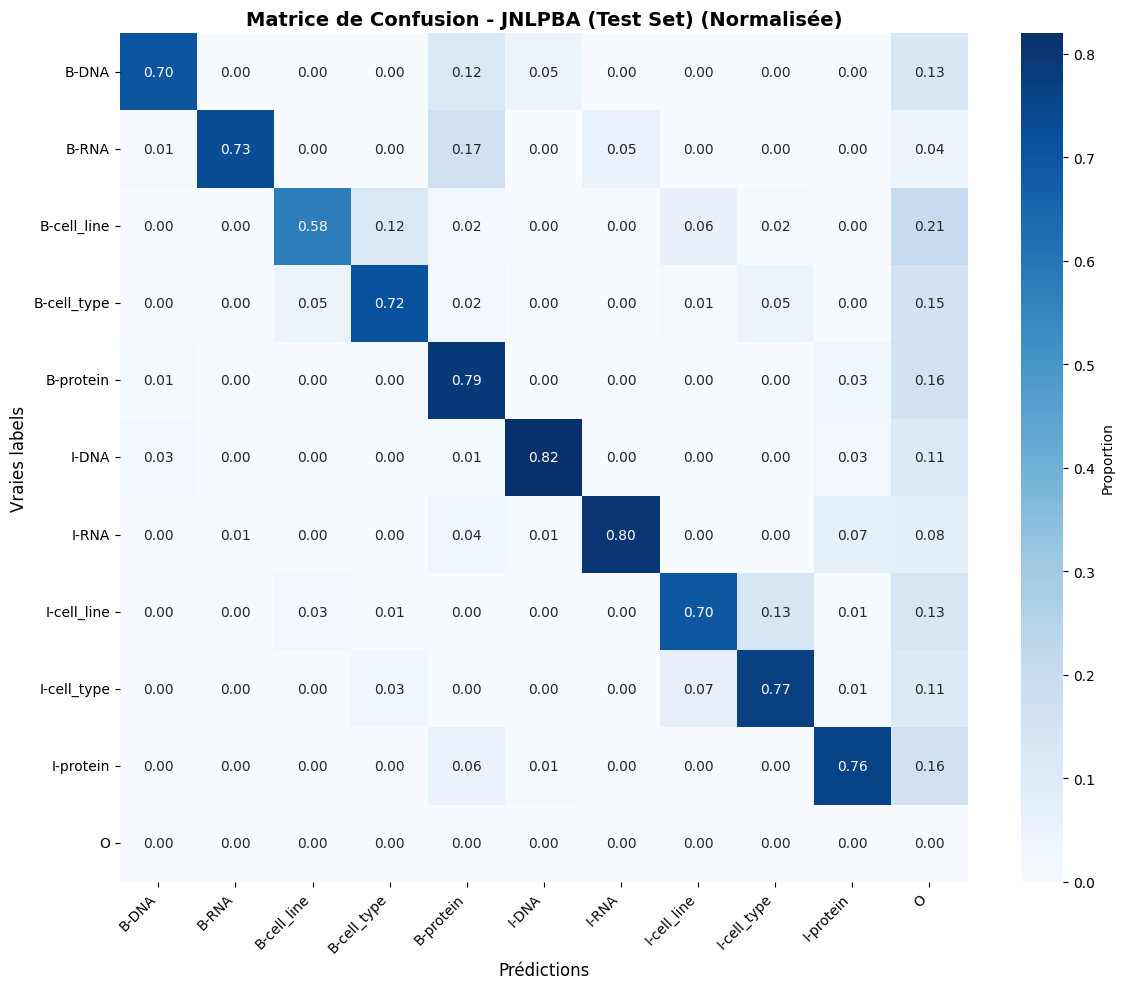

              precision    recall  f1-score   support

       B-DNA       0.84      0.70      0.77       855
       B-RNA       0.88      0.73      0.80        96
 B-cell_line       0.65      0.58      0.61       393
 B-cell_type       0.89      0.72      0.79      1729
   B-protein       0.89      0.79      0.84      4505
       I-DNA       0.91      0.82      0.86      1393
       I-RNA       0.92      0.80      0.86       156
 I-cell_line       0.69      0.70      0.69       792
 I-cell_type       0.91      0.77      0.84      2690
   I-protein       0.93      0.76      0.84      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.76     16829
   macro avg       0.77      0.67      0.72     16829
weighted avg       0.89      0.76      0.82     16829

B-DNA               : Precision=0.843, Recall=0.702, F1=0.766, Support=855
B-RNA               : Precision=0.875, Recall=0.729, F1=0.795, Support=96
B-cell_line         : Precision=0.650,

In [42]:
from sklearn.metrics import accuracy_score, classification_report

# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets, predictions)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions, targets) if t != 'O']
entity_targets = [t for p, t in zip(predictions, targets) if t != 'O']

if entity_targets:
    entity_accuracy = accuracy_score(entity_targets, entity_preds)
    print(f"Accuracy sur les entités: {entity_accuracy:.4f}")
    print(f"Nombre d'entités: {len(entity_targets):,}")
    print("\nRapport de classification (entités seulement):")
    print(classification_report(entity_targets, entity_preds, zero_division=0))
else:
    print("Aucune entité trouvée dans les cibles!")


if set(predictions) == set(targets) or all(isinstance(p, str) for p in predictions):
    plot_confusion_matrix_by_class(
        predictions=predictions,
        targets=targets,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10)
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets[:10])}")

La deuxième combinaison (“+ attention” sur WE)

In [43]:
model_we_attention, history_we_attention = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn=False,
    use_char_lstm=False,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=256,
    epochs=100,
    patience=8,
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 2,940,020


Training:   0%|          | 0/491 [00:00<?, ?it/s]

Training: 100%|██████████| 491/491 [01:12<00:00,  6.77it/s]


Epoch 01/100 | Train loss: 773.7449 | Dev loss: 502.8973 | P: 0.0587 R: 0.0748 F1: 0.0628 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.0628)


Training: 100%|██████████| 491/491 [01:03<00:00,  7.76it/s]


Epoch 02/100 | Train loss: 409.8002 | Dev loss: 390.5971 | P: 0.0677 R: 0.1430 F1: 0.0918 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.0918)


Training: 100%|██████████| 491/491 [01:00<00:00,  8.08it/s]


Epoch 03/100 | Train loss: 325.2198 | Dev loss: 331.3321 | P: 0.0686 R: 0.1450 F1: 0.0924 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.0924)


Training: 100%|██████████| 491/491 [01:02<00:00,  7.86it/s]


Epoch 04/100 | Train loss: 273.8072 | Dev loss: 300.3398 | P: 0.0670 R: 0.1497 F1: 0.0918 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:00<00:00,  8.13it/s]


Epoch 05/100 | Train loss: 240.1610 | Dev loss: 296.4231 | P: 0.0696 R: 0.1547 F1: 0.0879 | LR: 0.001000


Training: 100%|██████████| 491/491 [01:00<00:00,  8.05it/s]


Epoch 06/100 | Train loss: 218.1305 | Dev loss: 269.2815 | P: 0.0759 R: 0.1499 F1: 0.0927 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.0927)


Training: 100%|██████████| 491/491 [01:00<00:00,  8.10it/s]


Epoch 07/100 | Train loss: 202.9526 | Dev loss: 260.1607 | P: 0.0903 R: 0.1483 F1: 0.0985 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.0985)


Training: 100%|██████████| 491/491 [00:59<00:00,  8.28it/s]


Epoch 08/100 | Train loss: 190.6953 | Dev loss: 268.1446 | P: 0.1076 R: 0.1466 F1: 0.1137 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.1137)


Training: 100%|██████████| 491/491 [00:58<00:00,  8.36it/s]


Epoch 09/100 | Train loss: 180.8529 | Dev loss: 255.5070 | P: 0.1687 R: 0.1510 F1: 0.1073 | LR: 0.001000


Training: 100%|██████████| 491/491 [00:59<00:00,  8.26it/s]


Epoch 10/100 | Train loss: 172.0943 | Dev loss: 256.1280 | P: 0.2359 R: 0.1731 F1: 0.1491 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.1491)


Training: 100%|██████████| 491/491 [00:59<00:00,  8.19it/s]


Epoch 11/100 | Train loss: 162.7661 | Dev loss: 248.9087 | P: 0.2718 R: 0.2074 F1: 0.1962 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.1962)


Training: 100%|██████████| 491/491 [02:04<00:00,  3.93it/s]


Epoch 12/100 | Train loss: 155.1020 | Dev loss: 254.8944 | P: 0.2424 R: 0.2206 F1: 0.2080 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.2080)


Training: 100%|██████████| 491/491 [01:43<00:00,  4.73it/s]


Epoch 13/100 | Train loss: 147.8997 | Dev loss: 284.2745 | P: 0.3187 R: 0.2509 F1: 0.2514 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.2514)


Training: 100%|██████████| 491/491 [01:15<00:00,  6.52it/s]


Epoch 14/100 | Train loss: 140.7142 | Dev loss: 260.3661 | P: 0.2364 R: 0.2224 F1: 0.2023 | LR: 0.001000


Training: 100%|██████████| 491/491 [03:21<00:00,  2.44it/s]


Epoch 15/100 | Train loss: 134.2760 | Dev loss: 281.5468 | P: 0.2988 R: 0.2806 F1: 0.2727 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.2727)


Training: 100%|██████████| 491/491 [01:18<00:00,  6.26it/s]


Epoch 16/100 | Train loss: 128.1799 | Dev loss: 274.1810 | P: 0.3057 R: 0.3066 F1: 0.2895 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_attention/best_model.pt : (F1: 0.2895)


Training:  12%|█▏        | 57/491 [00:07<01:00,  7.18it/s]


KeyboardInterrupt: 

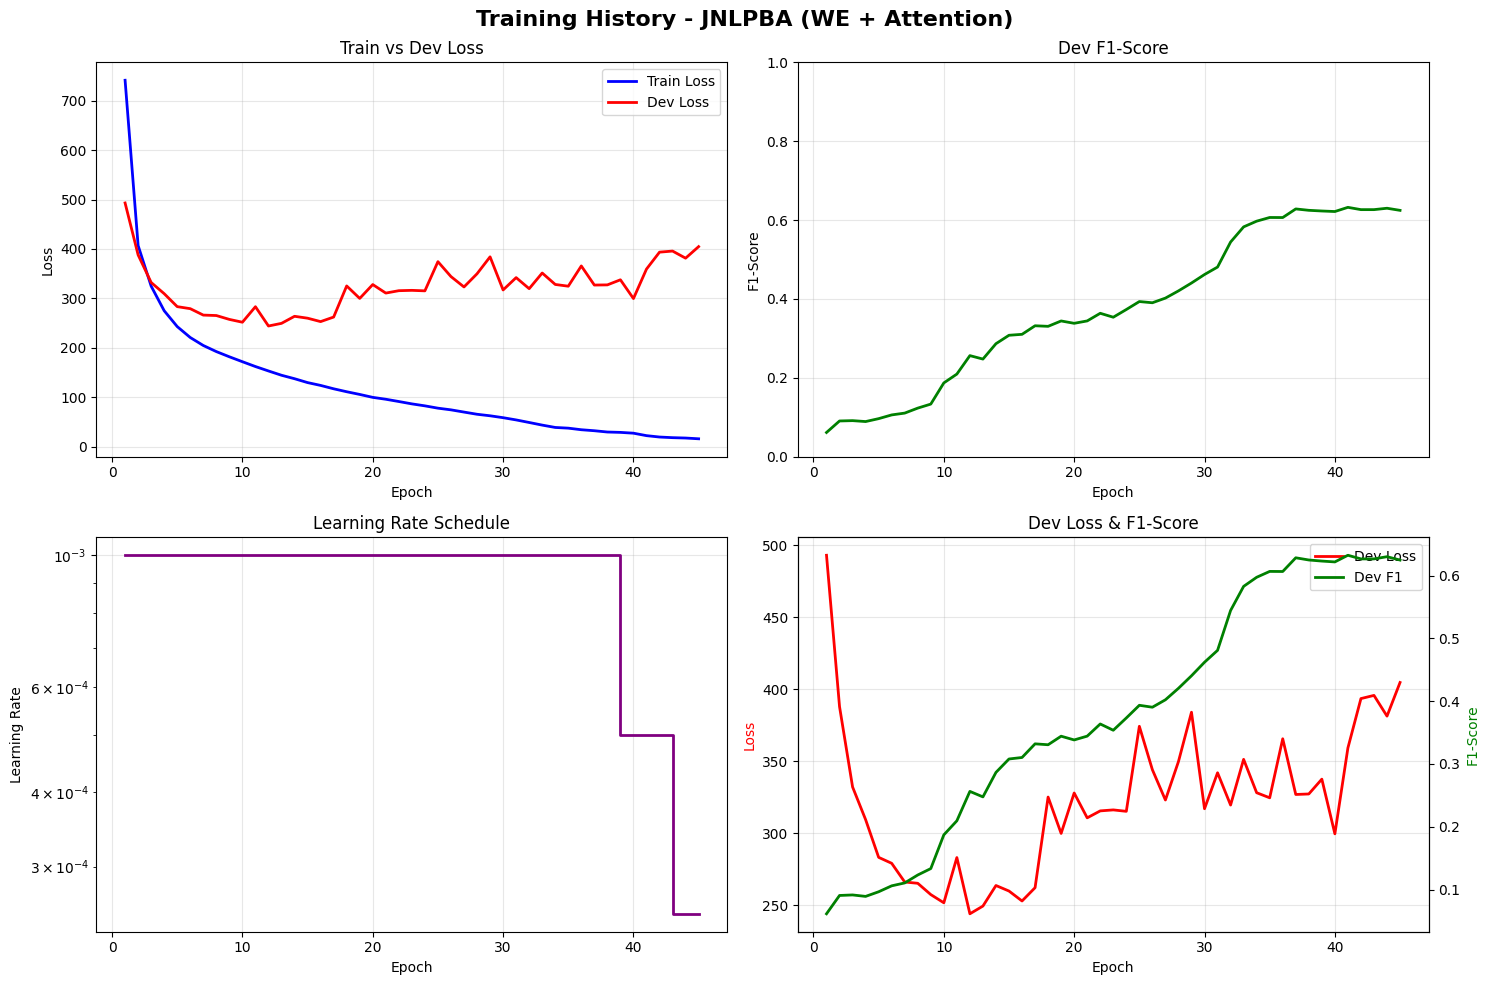

STATISTIQUES FINALES - JNLPBA (WE + Attention)
Meilleur F1-score (dev): 0.6323
Final train loss: 15.6164
Final dev loss: 404.7129
Final learning rate: 0.000250


In [16]:
plot_training_history(history_we_attention, dataset_name="JNLPBA (WE + Attention)")

In [21]:
model_path = "./checkpoints/JNLPBA/WE_attention/best_model.pt"
model_we_attention, device, idx_to_tag = load_trained_model(
    model_path=model_path,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=False,use_char_lstm=False,use_attention=True,use_fc_fusion=False
)

# 3. Faire des prédictions avec la version corrigée
test_loader = results_jnlpba['test_loader']
predictions_we_attention, targets_we_attention = predict_on_test_set(
    model=model_we_attention,
    test_loader=test_loader,
    device=device,
    idx_to_tag=idx_to_tag
)

Modèle chargé depuis: ./checkpoints/JNLPBA/WE_attention/best_model.pt
Best F1 enregistré: 0.6323
Époque: 40
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O



Accuracy globale: 0.8998
Accuracy sur les entités: 0.6564
Nombre d'entités: 16,829

Rapport de classification (entités seulement):
              precision    recall  f1-score   support

       B-DNA       0.72      0.58      0.64       855
       B-RNA       0.87      0.56      0.68        96
 B-cell_line       0.49      0.48      0.49       393
 B-cell_type       0.82      0.60      0.69      1729
   B-protein       0.87      0.71      0.79      4505
       I-DNA       0.79      0.72      0.75      1393
       I-RNA       0.89      0.48      0.62       156
 I-cell_line       0.46      0.63      0.53       792
 I-cell_type       0.88      0.61      0.72      2690
   I-protein       0.89      0.67      0.77      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.66     16829
   macro avg       0.70      0.55      0.61     16829
weighted avg       0.83      0.66      0.73     16829


Vérification des types:
  Type predictions[0]: <class 

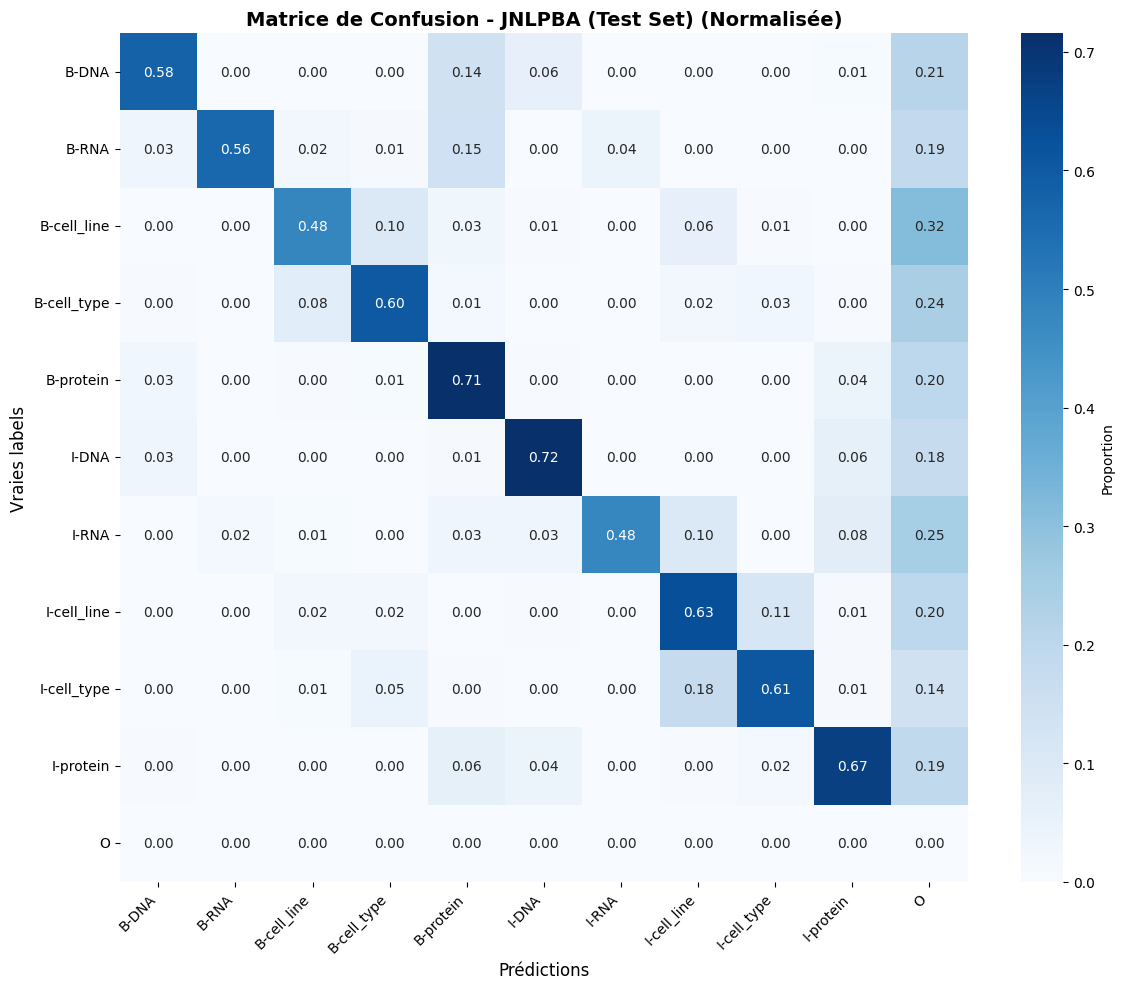

              precision    recall  f1-score   support

       B-DNA       0.72      0.58      0.64       855
       B-RNA       0.87      0.56      0.68        96
 B-cell_line       0.49      0.48      0.49       393
 B-cell_type       0.82      0.60      0.69      1729
   B-protein       0.87      0.71      0.79      4505
       I-DNA       0.79      0.72      0.75      1393
       I-RNA       0.89      0.48      0.62       156
 I-cell_line       0.46      0.63      0.53       792
 I-cell_type       0.88      0.61      0.72      2690
   I-protein       0.89      0.67      0.77      4220
           O       0.00      0.00      0.00         0

    accuracy                           0.66     16829
   macro avg       0.70      0.55      0.61     16829
weighted avg       0.83      0.66      0.73     16829

B-DNA               : Precision=0.724, Recall=0.577, F1=0.642, Support=855
B-RNA               : Precision=0.871, Recall=0.562, F1=0.684, Support=96
B-cell_line         : Precision=0.493,

In [25]:
from sklearn.metrics import accuracy_score, classification_report

# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_attention, predictions_we_attention)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_attention, targets_we_attention) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_attention, targets_we_attention) if t != 'O']

if entity_targets:
    entity_accuracy = accuracy_score(entity_targets, entity_preds)
    print(f"Accuracy sur les entités: {entity_accuracy:.4f}")
    print(f"Nombre d'entités: {len(entity_targets):,}")
    print("\nRapport de classification (entités seulement):")
    print(classification_report(entity_targets, entity_preds, zero_division=0))
else:
    print("Aucune entité trouvée dans les cibles!")


if set(predictions_we_attention) == set(targets_we_attention) or all(isinstance(p, str) for p in predictions_we_attention):
    plot_confusion_matrix_by_class(
        predictions=predictions_we_attention,
        targets=targets_we_attention,
        idx_to_tag=idx_to_tag,
        dataset_name='JNLPBA (Test Set)',
        normalize=True,
        figsize=(12, 10)
    )
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_attention[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_attention[:10])}")

WE + char(bi-lstm) + attention

In [30]:
model_we_attention, history_we_attention = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn=False,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=False,
    embedding_url=None,  
    lstm_hidden_dim=256,
    epochs=80,
    patience=4,
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,077,770


Training: 100%|██████████| 491/491 [01:09<00:00,  7.09it/s]


Epoch 01/80 | Train loss: 757.9188 | Dev loss: 502.8230 | P: 0.0644 R: 0.0858 F1: 0.0685 | LR: 0.001000
Meilleur modèle sauvegardé dans ./checkpoints/JNLPBA/WE_char_bilstm_attention/best_model.pt : (F1: 0.0685)


Training:  63%|██████▎   | 307/491 [00:42<00:25,  7.19it/s]


KeyboardInterrupt: 